In [ ]:
##############################################################################
## Fundamentals for pratical Text Analytics - document/word embeddings
##                                            more spacy, 
##                                            gensim to build our own ----> spacy
##                                            why:  dense numeric representations to capture meaning
##                                                  use downstream -> similarity, clustering, ML
##
##
## Learning goals:
##                 - continue spacy
##                 - foundational understanding of word vectors via Word2Vec
##                 - can roll our own vectors
##                 - generalized, pre-trained word vectors for S|UML tasks (intent classification)
##
##
## Great resources
##                 - https://spacy.io/usage/spacy-101
##                 - https://spacy.io/universe/category/courses
##
##
##############################################################################

In [ ]:
# installs
! pip install -U spacy 
! pip install -U textacy
! pip install newspaper3k
! pip install afinn
! pip install whatlies

In [ ]:
# imports
import spacy
from spacy import cli
from spacy import displacy

import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist, cdist, squareform
import seaborn as sns


# upcoming!
# from textacy.extract.keyterms import textrank
import gensim

import textacy

from newspaper import Article
import json

from afinn import Afinn


In [ ]:
# use spacy cli
MODEL = "en_core_web_md"

# https://spacy.io/models/en
cli.download(MODEL)

# nlp = language model
nlp = spacy.load(MODEL)

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [ ]:
############################################ WARMUP
##
##
## Scrape the Wikipedia Entry for the Netflix series Squid Game
## https://en.wikipedia.org/wiki/Squid_Game
##
## use the pre-loaded spacy NER model to parse the entities
## parse the entities into a dataframe
## create a barplot summarizing count by entity type
## TRICKY:  make it a horizontal barplot with the most frequent entity at the top of the chart
## 

In [ ]:
from newspaper import Article

article = Article("https://en.wikipedia.org/wiki/Squid_Game")
article.download()
article.parse()

sg = article.text

In [ ]:
sg

In [ ]:
# clean/remove the newline characters
# \n
sg = sg.replace("\n", "")

In [ ]:
# parse the doc
doc = nlp(sg)

In [ ]:
# extract the entities
ents = [(ent.text, ent.start_char, ent.end_char, ent.label_) for ent in doc.ents]

In [ ]:
ents[:5]

[('2021', 0, 4, 'CARDINAL'),
 ('South Korean', 5, 17, 'NORP'),
 ('Netflix', 76, 83, 'ORG'),
 ('Korean', 111, 117, 'NORP'),
 ('Squids', 178, 184, 'NORP')]

In [ ]:
len(ents)

898

In [ ]:
df = pd.DataFrame(ents, columns=['text', 'start', 'end', 'entity'])

In [ ]:
df.head(3)

,text,start,end,entity
0,2021,0,4,CARDINAL
1,South Korean,5,17,NORP
2,Netflix,76,83,ORG


In [ ]:
counts = df.entity.value_counts()
counts

PERSON         225
ORG            163
CARDINAL       135
DATE           117
NORP            70
GPE             57
WORK_OF_ART     46
ORDINAL         33
TIME            10
MONEY            9
LOC              6
PRODUCT          6
PERCENT          5
FAC              4
LANGUAGE         4
EVENT            3
QUANTITY         3
LAW              2
Name: entity, dtype: int64

In [ ]:
type(counts)

pandas.core.series.Series

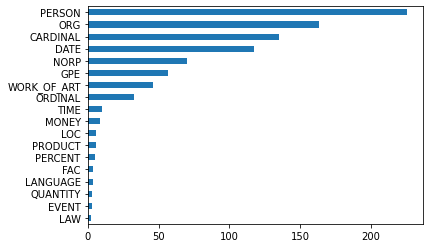

In [ ]:
counts.sort_values().plot(kind="barh")

🔥

In [ ]:
############################################ Word/Doc Vectors
##
##

In [ ]:
# lets review a simple document
tweet = "That movie from email@email.com was 🔥!  We can review it at www.bu.edu."

In [ ]:
# spacy is a pipeline
nlp.pipe_names

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']

In [ ]:
doc = nlp(tweet)
doc

That movie from email@email.com was 🔥!  We can review it at www.bu.edu.

In [ ]:
# remember, we can slice up docs into tokens/spans
token = doc[0]
token

That

In [ ]:
type(token)

spacy.tokens.token.Token

In [ ]:
# tokens have all sorts of attributes that were learned
token.like_url

False

In [ ]:
# worth noting, a document can be comprised of sentences
# remember that we used to download punkt from nltk?
# that was a sentence tokenizer (divide into sentences)
# spacy has this built in

# print out the two sentences
sentences = [sent for sent in doc.sents]

In [ ]:
sentences[0]

That movie from email@email.com was 🔥!

In [ ]:
[token.is_oov for token in sentences[0]]

[False, False, False, True, False, True, False]

In [ ]:
####################################### quick departure
# above we checked against spacy's learned vocabulary
# this is a check to see if a token is out-of-vocabulary (OOV)

# model reviews:
# https://spacy.io/usage/models


In [ ]:
# this is just for reference
# 

v = nlp.vocab.vectors
v.shape

(20000, 300)

In [ ]:
# spacy stores text and tokens effeciently 
# https://spacy.io/usage/spacy-101#vocab

# spacy provides a way to lookup the vectors
nlp.vocab.strings["golf"]

# and we can reverse
nlp.vocab.strings[18149141486079540445]

## spacy is very flexible, and while vectors can be added and edited, 
## we can just include our own, which we will do later

'golf'

In [ ]:
#######################################  Vectors/Embeddings
##
## You have heard me use this term quite a bit
## we have seen this via PCA ----> take a large feature space and re-represent this in a new space
##     the goal was to encode information and reduce noise, right?
##
## we saw this in Tsne (2 embeddings) and UMAP (can be 2 or more depending on our needs)
## 
## 
## Well in text, we have the same idea
## we could always use the tools above, but there this is a "hot" field right now -> embeddings




![](https://miro.medium.com/max/2224/0*K5a1Ws_nsbEjhbYk.png)

> Above we can see words can be represented in these highly dimensional spaces.  The aim is to encapsulate context.  Remember bag-of-words removes sequence/order!


![](https://jalammar.github.io/images/word2vec/king-analogy-viz.png)

![](https://miro.medium.com/max/1400/1*cuOmGT7NevP9oJFJfVpRKA.png)


In [ ]:
# get some vectors

king = nlp("king").vector
man = nlp("man").vector
woman = nlp("woman").vector
queen = nlp("queen").vector
jester = nlp("jester").vector
court = nlp("court").vector
golf = nlp("golf").vector

In [ ]:
# what do we have
king.shape

(300,)

In [ ]:
# a quick preview
king[:5]

array([ 0.31542, -0.35068,  0.42923, -0.53825, -0.1848 ], dtype=float32)

In [ ]:
# some math
test = king - man + woman

In [ ]:
test[:5]

array([ 0.514087  , -0.27846   ,  0.242767  ,  0.04548997, -0.259425  ],
      dtype=float32)

In [ ]:
# the comparison set

lookups = np.stack([queen, jester, court, golf])
lookups.shape

(4, 300)

In [ ]:
# we can use cdist manually
comp_list = ['queen', 'jester', 'court', 'golf']

# the test calc needs to be 2-d
test = np.expand_dims(test, 0)


In [ ]:
test.shape

(1, 300)

In [ ]:
# the comps -- cdist expected test to be 2d, so we used expand dims above

comps = cdist(test, lookups, metric="cosine")
comps



array([[0.21191557, 0.75962686, 0.64762929, 0.84203839]])

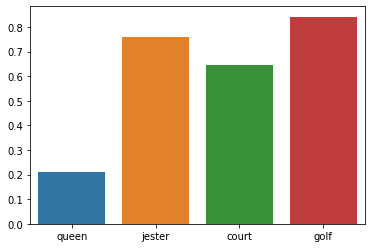

In [ ]:
# lets plot the distances as a barplot
sns.barplot(x=comp_list, y=comps[0])


In [ ]:
# so what did we see
# it was a small test, but conceptually we saw how these vectors can be compared
# we used distance to compare the numeric vectors and manually find the most similar
# contrived example, but sets up the concepts

In [ ]:
# going back to the simple two sentence corpus
doc

That movie from email@email.com was 🔥!  We can review it at www.bu.edu.

In [ ]:
[(token.text, token.is_oov) for token in doc]

[('That', False),
 ('movie', False),
 ('from', False),
 ('email@email.com', True),
 ('was', False),
 ('🔥', True),
 ('!', False),
 (' ', True),
 ('We', False),
 ('can', False),
 ('review', False),
 ('it', False),
 ('at', False),
 ('www.bu.edu', True),
 ('.', False)]

In [ ]:
fire = nlp('🔥')

In [ ]:
# get the vectors
fire.vector

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [ ]:
# there are some great toolkits that have been created
# to breakdown and explore all sorts of embeddings

# lots you can do here, but from some of the dev rel folks at rasa, which
# we will briefly see next class!
# https://github.com/RasaHQ/whatlies

In [ ]:
## let's go back to the tweet


In [ ]:
# what do we get for a token that is OOV?

# nlp('🔥').vector




In [ ]:
## what do you notice?
## this is a convention of spacy
## for OOV tokens, spacy doesn't fail, it simply returns an array of zeroes

In [ ]:
# lets review a doc vector
doc.vector

array([-7.21276700e-02,  1.57519653e-01, -3.79344672e-02, -1.07518069e-01,
        5.73830195e-02,  7.37524703e-02,  3.41576003e-02, -1.48227662e-01,
        2.47825775e-02,  1.69008005e+00, -1.24916121e-01,  9.29670632e-02,
        1.58001557e-01, -8.06328580e-02, -1.25308990e-01, -7.17509910e-02,
       -2.37948000e-02,  8.80983293e-01, -2.14851275e-01, -6.95836619e-02,
        5.53222150e-02, -1.60227016e-01,  5.85140623e-02,  4.41635288e-02,
       -2.03860011e-02,  1.93691120e-01, -1.14692956e-01, -1.08445264e-01,
        2.34624632e-02, -6.11014515e-02,  1.54627319e-02,  2.40390897e-02,
        7.22037512e-04,  1.50506943e-01, -7.51272738e-02, -3.43301846e-03,
       -6.18986273e-03,  1.34531945e-01, -8.07618052e-02, -2.41512880e-02,
        1.40986766e-03,  7.79016018e-02,  3.50073352e-02, -1.05595261e-01,
        1.12988874e-01,  9.88095999e-02, -2.03205347e-01, -7.42548034e-02,
       -5.65054677e-02, -9.38460883e-03,  5.99264055e-02,  2.35363357e-02,
        9.01833083e-03,  

In [ ]:
doc

That movie from email@email.com was 🔥!  We can review it at www.bu.edu.

In [ ]:
dv = doc.vector

In [ ]:
# how do we think the doc vector is constructed?
vecs = []
for token in doc:
  vecs.append(token.vector)

# make it a numpy array
va = np.array(vecs)

vam = va.mean(axis=0)
vam.shape

# compare
np.all(vam == dv)

True

(15, 300)

In [ ]:
# remember spans?
# same still applies - token vectors are averaged over the docs and spans to represent the document

In [ ]:
#######################################  YOUR TURN
## 
## scrape the text from the three articles from the URLs below
## generate the doc vectors
## what is the most similar article to URL1 via cosine distance?
#
# URL1 = "https://www.boston.com/weather/weather/2021/11/26/boston-ma-snow-forecast-friday-nov-26-2021/"
# URL2 = "https://www.sportingnews.com/us/fantasy/news/nfl-week-12-weather-updates-lack-of-rain-wind-snow-in-forecast-eases-fantasy-football-start-em-sit-em-decisions/lueadzpkttxa1l2nzyr70hr18"
# URL3 = "https://www.marketwatch.com/story/the-u-s-stock-market-suffers-ugly-black-friday-selloff-here-are-the-biggest-losers-and-winners-11637952898"
## 


In [ ]:
#######################################  UP NEXT
## 
## Learn your own, domain-specific, word vectors
##
## Next Notebook
# 